# Evaluation of hourly bias-corrected WBGT


In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.CRITICAL)

import glob
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature

import sys
# sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
# import utils




In [2]:
# Variable specific settings

var = 'wbgt'
name = 'wet-bulb globe temperature'
units = 'degC'
cmap = 'RdBu_r'

inst= "CSIRO" #"BOM" #"CSIRO"
gcm= "ACCESS-CM2"
rcm= "CCAM-v2203-SN" #"BARPA-R" #"CCAM-v2203-SN"
yr_start="1980-01-01"
yr_end="2014-12-31"
reference= "BARRA-R2"
start_date_fut = '2065-01-01'
end_date_fut = '2099-12-31'


In [3]:
# Metric calculation
# Annual mean
def calc_mean(da, var):
    """Calculate the mean"""
    da =  da[var].sel(time=slice(yr_start,yr_end))
    if var == 'pr':
        mean = da.groupby('time.year').sum(dim="time").mean(dim='year').compute()
    else:
        mean = da.groupby('time.year').mean(dim="time").mean(dim='year').compute()
        
    return mean

# # Percentiles
# def calc_perc(da, var):
#     """Calculate the averaged 5-year maximum (minimum for Tasmin)"""
    
#     if var == 'pr' or var == 'tasmax' or var == 'wbgt' or var == 'wbgtAdjust':
#         mode = 'upper percentiles'
#         da =  da[var].sel(time=slice(yr_start,yr_end))
#         percentiles_99 = da.quantile(0.99, dim='time').compute()
#         percentiles_995 = da.quantile(0.995, dim='time').compute()
#         percentiles_999 = da.quantile(0.999, dim='time').compute()
#         return percentiles_99, percentiles_995, percentiles_999, mode
#     else:
#         mode = 'lower percentiles'
#         da =  da[var].sel(time=slice(yr_start,yr_end))
#         percentiles_01 = da.quantile(0.01, dim='time').compute()
#         percentiles_005 = da.quantile(0.005, dim='time').compute()
#         percentiles_001 = da.quantile(0.001, dim='time').compute()  
#         return percentiles_01, percentiles_005, percentiles_001, mode

# Climatology
def calc_clim(da, var):
    """Calculate the monthly climatology"""
    da =  da[var].sel(time=slice(yr_start,yr_end))
    if var == 'pr':
        da_monthly = da.resample(time='1M').sum()
        climatology = da_monthly.groupby('time.month').mean('time').compute()
    else:
        climatology = da.groupby('time.month').mean(dim='time').compute()
    
    jan = climatology.sel(month=1)
    feb = climatology.sel(month=2)
    mar = climatology.sel(month=3)
    apr = climatology.sel(month=4)
    may = climatology.sel(month=5)
    jun = climatology.sel(month=6)
    jul = climatology.sel(month=7)
    aug = climatology.sel(month=8)
    sep = climatology.sel(month=9)
    oct = climatology.sel(month=10)
    nov = climatology.sel(month=11)
    dec = climatology.sel(month=12)
    return jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec   

# Change signal
def calc_change_signal(da_future, da, var):
    da_future = da_future[var].sel(time=slice(start_date_fut,end_date_fut))
    da = da[var].sel(time=slice(yr_start,yr_end))
    """Calculate the difference in the change signal between GCM and RCM """
    
    if var == 'pr':
        change_signal = ((da_future.mean(dim='time') - da.mean(dim='time'))/abs(da.mean(dim='time'))*100).compute()
    else:
        change_signal = (da_future.mean(dim='time') - da.mean(dim='time')).compute()
    
    return change_signal

In [4]:
# get data historical

path_ref= f"/g/data/ia39/australian-climate-service/test-data/BARRA2/output/reanalysis/AUST-11/BOM/ERA5/historical/hres/BARRAR2/v1/1hr/wbgt/latest-native-contiguous/"
path_raw_model= f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/DD/AUST-11i/{inst}/{gcm}/historical/r4i1p1f1/{rcm}/v1-r1/1hr/wbgt/latest-conservative-contiguous/"
path_correct_model = f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/bias-adjusted-output/AUST-11i/{inst}/{gcm}/historical/r4i1p1f1/{rcm}/v1-r1-ACS-QME-BARRAR2-1980-2022/1hr/wbgtAdjust/v20250311/"

files_ref= glob.glob(path_ref + '*.nc')
files_raw_model= glob.glob(path_raw_model + '*.nc')
files_correct_model= glob.glob(path_correct_model + '*.nc')

da_ref = xr.open_mfdataset(files_ref, combine='by_coords', engine='h5netcdf', chunks={})
da_raw_model = xr.open_mfdataset(files_raw_model, combine='by_coords', engine='h5netcdf', chunks={})
da_correct_model = xr.open_mfdataset(files_correct_model, combine='by_coords', engine='h5netcdf', chunks={})

In [ ]:
# get data future

path_raw_model_fut= f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/DD/AUST-11i/{inst}/{gcm}/ssp370/r4i1p1f1/{rcm}/v1-r1/1hr/wbgt/latest-conservative-contiguous/"
path_correct_model_fut = f"/g/data/ia39/australian-climate-service/test-data/CORDEX/output-CMIP6/bias-adjusted-output/AUST-11i/{inst}/{gcm}/ssp370/r4i1p1f1/{rcm}/v1-r1-ACS-QME-BARRAR2-1980-2022/1hr/wbgtAdjust/v20250311/"

files_raw_model_fut= glob.glob(path_raw_model_fut + '*.nc')
files_correct_model_fut= glob.glob(path_correct_model_fut + '*.nc')

da_raw_model_fut = xr.open_mfdataset(files_raw_model_fut, combine='by_coords', engine='h5netcdf', chunks={})
da_correct_model_fut = xr.open_mfdataset(files_correct_model_fut, combine='by_coords', engine='h5netcdf', chunks={})

## Annual mean 

In [ ]:
# Annual mean
da_ref_mean = calc_mean(da_ref, "wbgt")
da_raw_model_mean = calc_mean(da_raw_model, "wbgt")
da_corret_model_mean = calc_mean(da_correct_model, "wbgtAdjust")

In [ ]:
# Bias Annual mean
task="annual-mean-bias"
calc= "annual mean"
da_raw_model_mean_bias = da_raw_model_mean - da_ref_mean
mae_da_raw_model_mean_bias = np.nanmean(np.abs(da_raw_model_mean_bias))

da_corret_model_mean_bias = da_corret_model_mean - da_ref_mean
mae_da_corret_model_mean_bias = np.nanmean(np.abs(da_corret_model_mean_bias)) 

In [ ]:
# Plot Annul Mean

levels_bias = np.arange(-1, 1.25, 0.25)
levels_ref = np.arange(5, 30, 2.5)

ncols = 3 
nrows = 1
plot_nums = np.arange(1, (ncols * nrows) + 1)

fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

plot_index = 0

ax1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_ref_mean.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="hot_r",
    levels=levels_ref,
    extend='both',
    cbar_kwargs={'label': units},
)
ax1.set_title(f"{reference} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}")
ax1.coastlines()


plot_index = plot_index + 1

ax2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_raw_model_mean_bias.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax2.text(0.02, 0.02, f'MAE: {mae_da_raw_model_mean_bias:.2f} {units}', transform=ax2.transAxes, fontsize='large')
ax2.set_title(gcm+'-'+rcm+' (raw)')
ax2.coastlines()


plot_index = plot_index + 1

ax3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
da_corret_model_mean_bias.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax3.text(0.02, 0.02, f'MAE: {mae_da_corret_model_mean_bias:.2f} {units}', transform=ax3.transAxes, fontsize='large')
ax3.set_title(gcm+'-'+rcm+' (bias-corrected)')
ax3.coastlines()

outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
# plt.suptitle(f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')
fig.text(0.43, 0.97,  # X and Y position in figure coordinates
         f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')
plt.savefig(outfile, dpi=300, bbox_inches='tight')

## Percentiles

In [9]:
# # Percentiles
# da_ref_perc1, da_ref_perc2, da_ref_perc3, _ = calc_perc(da_ref, "wbgt")
# _, _, _, mode= calc_perc(da_ref, "wbgt")
# da_raw_model_perc1, da_raw_model_perc2, da_raw_model_perc3, _ = calc_perc(da_raw_model, "wbgt")
# da_corret_model_perc1, da_corret_model_perc2, da_corret_model_perc3, _ = calc_perc(da_correct_model, "wbgtAdjust")

In [10]:
# # Bias Percentiles
# task="percentiles_bias"
# calc="percentiles"


# # 99th p.
# da_raw_model_perc_bias1 = da_raw_model_perc1 - da_ref_perc1
# mae_da_raw_model_perc_bias1 = np.nanmean(np.abs(da_raw_model_perc_bias1))

# da_corret_model_perc_bias1 = da_corret_model_perc1 - da_ref_perc1
# mae_da_corret_model_perc_bias1 = np.nanmean(np.abs(da_corret_model_perc_bias1)) 

# # 99.5th p.
# da_raw_model_perc_bias2 = da_raw_model_perc2 - da_ref_perc2
# mae_da_raw_model_perc_bias2 = np.nanmean(np.abs(da_raw_model_perc_bias2))

# da_corret_model_perc_bias2 = da_corret_model_perc2 - da_ref_perc2
# mae_da_corret_model_perc_bias2 = np.nanmean(np.abs(da_corret_model_perc_bias2)) 

# # 99.9th p.
# da_raw_model_perc_bias3 = da_raw_model_perc3 - da_ref_perc3
# mae_da_raw_model_perc_bias3 = np.nanmean(np.abs(da_raw_model_perc_bias3))

# da_corret_model_perc_bias3 = da_corret_model_perc3 - da_ref_perc3
# mae_da_corret_model_perc_bias3 = np.nanmean(np.abs(da_corret_model_perc_bias3))       

 

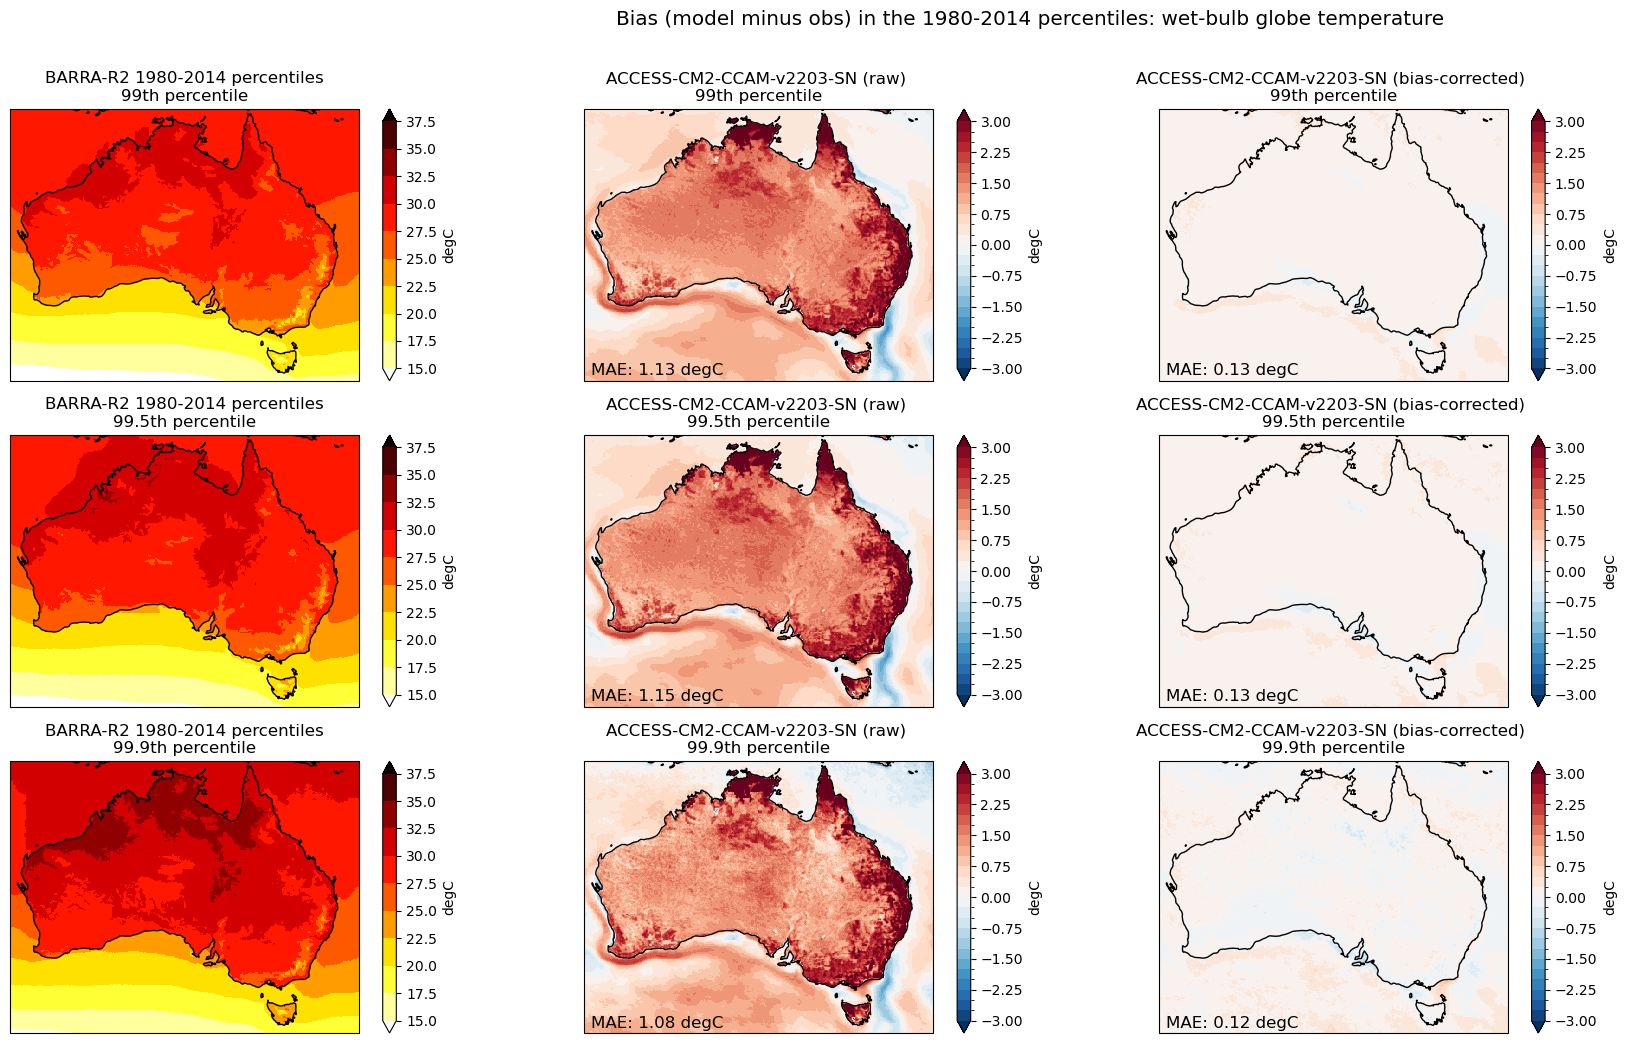

In [11]:
# # Plot Percentiles

# levels_bias = np.arange(-3, 3.25, 0.25)
# levels_ref = np.arange(15, 40, 2.5)

# if var == 'pr' or var == 'tasmax' or var == 'wbgt' or var == 'wbgtAdjust':
#     percentiles = ['99th', '99.5th', '99.9th']  
# elif var == 'tasmin':
#     percentiles = ['1st', '0.5th', '0.1st']
# else:
#     print('Invalid variable')

# ncols = 3 
# nrows = 3
# plot_nums = np.arange(1, (ncols * nrows) + 1)

# fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

# plot_index = 0

# for row, percentile in enumerate(percentiles):
#     if percentile == '99th':
#         num="1"
#         ax_num=[1,2,3]
#     elif percentile  == '99.5th':
#         num="2"
#         ax_num=[4,5,6]       
#     elif percentile  == '99.9th':
#         num="3"
#         ax_num=[7,8,9]
#     else:
#         print('Invalid percentile value or invalid variable')
    
#     globals()[f"ax{ax_num[0]}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
#     globals()[f"da_ref_perc{num}"].plot(
#         ax=globals()[f"ax{ax_num[0]}"],
#         transform=ccrs.PlateCarree(),
#         cmap="hot_r",
#         levels=levels_ref,
#         extend='both',
#         cbar_kwargs={'label': units},
#     )
#     globals()[f"ax{ax_num[0]}"].set_title(f"{reference} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}\n{percentile} percentile")
#     globals()[f"ax{ax_num[0]}"].coastlines()
    
    
#     plot_index = plot_index + 1
    
#     globals()[f"ax{ax_num[1]}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
#     globals()[f"da_raw_model_perc_bias{num}"].plot(
#         ax=globals()[f"ax{ax_num[1]}"],
#         transform=ccrs.PlateCarree(),
#         cmap=cmap,
#         levels=levels_bias,
#         extend='both',
#         cbar_kwargs={'label': units},
#     )
#     globals()[f"ax{ax_num[1]}"].text(0.02, 0.02, f'MAE: {globals()[f"mae_da_raw_model_perc_bias{num}"]:.2f} {units}', transform=globals()[f"ax{ax_num[1]}"].transAxes, fontsize='large')
#     globals()[f"ax{ax_num[1]}"].set_title(f"{gcm}-{rcm} (raw) \n{percentile} percentile")
#     globals()[f"ax{ax_num[1]}"].coastlines()
    
    
#     plot_index = plot_index + 1
    
#     globals()[f"ax{ax_num[2]}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
#     globals()[f"da_corret_model_perc_bias{num}"].plot(
#         ax=globals()[f"ax{ax_num[2]}"],
#         transform=ccrs.PlateCarree(),
#         cmap=cmap,
#         levels=levels_bias,
#         extend='both',
#         cbar_kwargs={'label': units},
#     )
#     globals()[f"ax{ax_num[2]}"].text(0.02, 0.02, f'MAE: {globals()[f"mae_da_corret_model_perc_bias{num}"]:.2f} {units}', transform=globals()[f"ax{ax_num[2]}"].transAxes, fontsize='large')
#     globals()[f"ax{ax_num[2]}"].set_title(f"{gcm}-{rcm} (bias-corrected) \n{percentile} percentile")
#     globals()[f"ax{ax_num[2]}"].coastlines()
#     plot_index = plot_index + 1

# outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
# # plt.suptitle(f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')

# fig.text(0.43, 0.95,  # X and Y position in figure coordinates
#          f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')

# plt.savefig(outfile, dpi=300, bbox_inches='tight')

## Climatology

In [12]:
# Climatology

jan_ref,feb_ref,mar_ref,apr_ref,may_ref,jun_ref,jul_ref,aug_ref,sep_ref,oct_ref,nov_ref,dec_ref  = calc_clim(da_ref, "wbgt")
jan_raw_model,feb_raw_model,mar_raw_model,apr_raw_model,may_raw_model,jun_raw_model,jul_raw_model,aug_raw_model,sep_raw_model,oct_raw_model,nov_raw_model,dec_raw_model  = calc_clim(da_raw_model, "wbgt")
jan_correct_model,feb_correct_model,mar_correct_model,apr_correct_model,may_correct_model,jun_correct_model,jul_correct_model,aug_correct_model,sep_correct_model,oct_correct_model,nov_correct_model,dec_correct_model  = calc_clim(da_correct_model, "wbgtAdjust")

In [13]:
# Bias climatology
task="climatology_bias"
calc="climatology"

# Jan
da_raw_model_clim_bias_jan = jan_raw_model - jan_ref
mae_da_raw_model_clim_bias_jan = np.nanmean(np.abs(da_raw_model_clim_bias_jan))

da_correct_model_clim_bias_jan = jan_correct_model - jan_ref
mae_da_correct_model_clim_bias_jan = np.nanmean(np.abs(da_correct_model_clim_bias_jan))

# Feb
da_raw_model_clim_bias_feb = feb_raw_model - feb_ref
mae_da_raw_model_clim_bias_feb = np.nanmean(np.abs(da_raw_model_clim_bias_feb))

da_correct_model_clim_bias_feb = feb_correct_model - feb_ref
mae_da_correct_model_clim_bias_feb = np.nanmean(np.abs(da_correct_model_clim_bias_feb))

# March
da_raw_model_clim_bias_mar = mar_raw_model - mar_ref
mae_da_raw_model_clim_bias_mar = np.nanmean(np.abs(da_raw_model_clim_bias_mar))

da_correct_model_clim_bias_mar = mar_correct_model - mar_ref
mae_da_correct_model_clim_bias_mar = np.nanmean(np.abs(da_correct_model_clim_bias_mar))

# April
da_raw_model_clim_bias_apr = apr_raw_model - apr_ref
mae_da_raw_model_clim_bias_apr = np.nanmean(np.abs(da_raw_model_clim_bias_apr))

da_correct_model_clim_bias_apr = apr_correct_model - apr_ref
mae_da_correct_model_clim_bias_apr = np.nanmean(np.abs(da_correct_model_clim_bias_apr))

# May
da_raw_model_clim_bias_may = may_raw_model - may_ref
mae_da_raw_model_clim_bias_may = np.nanmean(np.abs(da_raw_model_clim_bias_may))

da_correct_model_clim_bias_may = may_correct_model - may_ref
mae_da_correct_model_clim_bias_may = np.nanmean(np.abs(da_correct_model_clim_bias_may))

# June
da_raw_model_clim_bias_jun = jun_raw_model - jun_ref
mae_da_raw_model_clim_bias_jun = np.nanmean(np.abs(da_raw_model_clim_bias_jun))

da_correct_model_clim_bias_jun = jun_correct_model - jun_ref
mae_da_correct_model_clim_bias_jun = np.nanmean(np.abs(da_correct_model_clim_bias_jun))

# July
da_raw_model_clim_bias_jul = jul_raw_model - jul_ref
mae_da_raw_model_clim_bias_jul = np.nanmean(np.abs(da_raw_model_clim_bias_jul))

da_correct_model_clim_bias_jul = jul_correct_model - jul_ref
mae_da_correct_model_clim_bias_jul = np.nanmean(np.abs(da_correct_model_clim_bias_jul))

# August
da_raw_model_clim_bias_aug = aug_raw_model - aug_ref
mae_da_raw_model_clim_bias_aug = np.nanmean(np.abs(da_raw_model_clim_bias_aug))

da_correct_model_clim_bias_aug = aug_correct_model - aug_ref
mae_da_correct_model_clim_bias_aug = np.nanmean(np.abs(da_correct_model_clim_bias_aug))

# September
da_raw_model_clim_bias_sep = sep_raw_model - sep_ref
mae_da_raw_model_clim_bias_sep = np.nanmean(np.abs(da_raw_model_clim_bias_sep))

da_correct_model_clim_bias_sep = sep_correct_model - sep_ref
mae_da_correct_model_clim_bias_sep = np.nanmean(np.abs(da_correct_model_clim_bias_sep))

# October
da_raw_model_clim_bias_oct = oct_raw_model - oct_ref
mae_da_raw_model_clim_bias_oct = np.nanmean(np.abs(da_raw_model_clim_bias_oct))

da_correct_model_clim_bias_oct = oct_correct_model - oct_ref
mae_da_correct_model_clim_bias_oct = np.nanmean(np.abs(da_correct_model_clim_bias_oct))

# November
da_raw_model_clim_bias_nov = nov_raw_model - nov_ref
mae_da_raw_model_clim_bias_nov = np.nanmean(np.abs(da_raw_model_clim_bias_nov))

da_correct_model_clim_bias_nov = nov_correct_model - nov_ref
mae_da_correct_model_clim_bias_nov = np.nanmean(np.abs(da_correct_model_clim_bias_nov))


# December
da_raw_model_clim_bias_dec = dec_raw_model - dec_ref
mae_da_raw_model_clim_bias_dec = np.nanmean(np.abs(da_raw_model_clim_bias_dec))

da_correct_model_clim_bias_dec = dec_correct_model - dec_ref
mae_da_correct_model_clim_bias_dec = np.nanmean(np.abs(da_correct_model_clim_bias_dec))

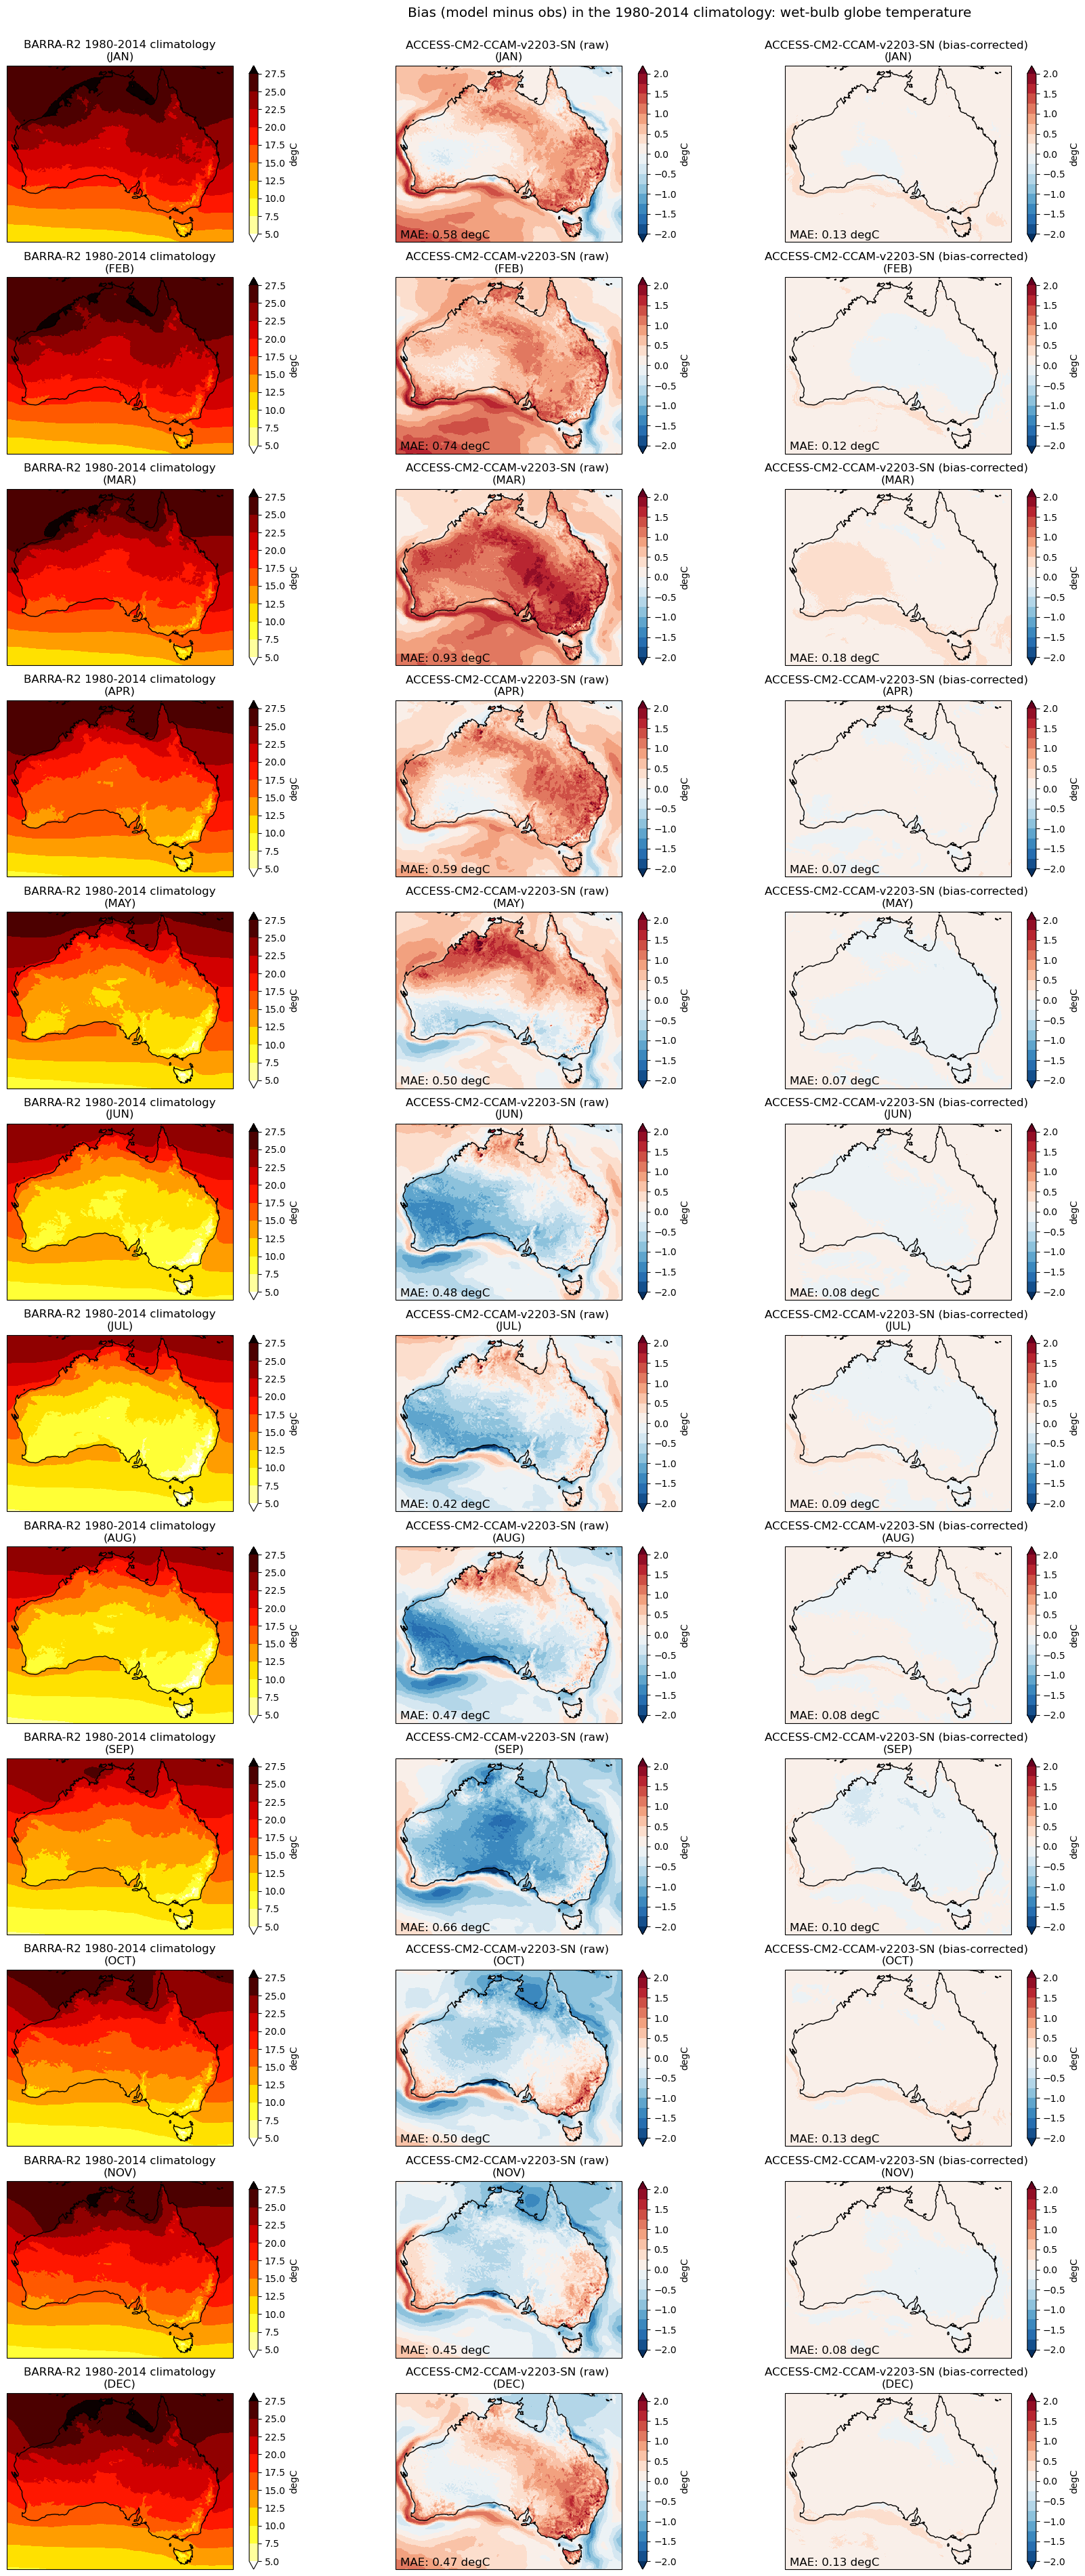

In [14]:
# Plot climatology

levels_bias = np.arange(-2, 2.25, 0.25)
levels_ref = np.arange(5, 30, 2.5)

months= ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

ncols = 3 
nrows = len(months)
plot_nums = np.arange(1, (ncols * nrows) + 1)

fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

plot_index = 0
ax_num=0 
for row, month in enumerate(months):    
    globals()[f"ax{ax_num+1}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    globals()[f"{month}_ref"].plot(
        ax=globals()[f"ax{ax_num+1}"],
        transform=ccrs.PlateCarree(),
        cmap="hot_r",
        levels=levels_ref,
        extend='both',
        cbar_kwargs={'label': units},
    )
    globals()[f"ax{ax_num+1}"].set_title(f"{reference} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}\n({month.upper()})")
    globals()[f"ax{ax_num+1}"].coastlines()
    
    
    plot_index = plot_index + 1
    
    globals()[f"ax{ax_num+2}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    globals()[f"da_raw_model_clim_bias_{month}"].plot(
        ax=globals()[f"ax{ax_num+2}"],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels_bias,
        extend='both',
        cbar_kwargs={'label': units},
    )
    globals()[f"ax{ax_num+2}"].text(0.02, 0.02, f'MAE: {globals()[f"mae_da_raw_model_clim_bias_{month}"]:.2f} {units}', transform=globals()[f"ax{ax_num+2}"].transAxes, fontsize='large')
    globals()[f"ax{ax_num+2}"].set_title(f"{gcm}-{rcm} (raw) \n({month.upper()})")
    globals()[f"ax{ax_num+2}"].coastlines()
    
    
    plot_index = plot_index + 1
    
    globals()[f"ax{ax_num+3}"] = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    globals()[f"da_correct_model_clim_bias_{month}"].plot(
        ax=globals()[f"ax{ax_num+3}"],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels_bias,
        extend='both',
        cbar_kwargs={'label': units},
    )
    globals()[f"ax{ax_num+3}"].text(0.02, 0.02, f'MAE: {globals()[f"mae_da_correct_model_clim_bias_{month}"]:.2f} {units}', transform=globals()[f"ax{ax_num+3}"].transAxes, fontsize='large')
    globals()[f"ax{ax_num+3}"].set_title(f"{gcm}-{rcm} (bias-corrected) \n({month.upper()})")
    globals()[f"ax{ax_num+3}"].coastlines()
    plot_index = plot_index + 1
    ax_num=ax_num+3

outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
# plt.suptitle(f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')

fig.text(0.43, 0.895, f"Bias (model minus obs) in the {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {calc}: {name}", fontsize='x-large')

plt.savefig(outfile, dpi=300, bbox_inches='tight')

## Change signal

In [ ]:
# change signal
change_raw_model = calc_change_signal(da_raw_model_fut, da_raw_model, "wbgt") 
change_correct_model = calc_change_signal(da_correct_model_fut, da_correct_model, "wbgtAdjust") 


In [ ]:
# Change signal spatial average

task="change_signal"
calc= "change signal"

ave_change_raw_model = np.nanmean(change_raw_model) 
ave_change_correct_model = np.nanmean(change_correct_model) 


In [ ]:
# Plot Change signal

levels_bias = np.arange(0, 5, 0.5)

ncols = 2 
nrows = 1
plot_nums = np.arange(1, (ncols * nrows) + 1)

fig = plt.figure(figsize=[7 * ncols, 4 * nrows])

plot_index = 0


ax2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
change_raw_model.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax2.text(0.02, 0.02, f'MAE: {ave_change_raw_model:.2f} {units}', transform=ax2.transAxes, fontsize='large')
ax2.set_title(gcm+'-'+rcm+' (raw)')
ax2.coastlines()


plot_index = plot_index + 1

ax3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
change_correct_model.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    levels=levels_bias,
    extend='both',
    cbar_kwargs={'label': units},
)
ax3.text(0.02, 0.02, f'MAE: {ave_change_correct_model:.2f} {units}', transform=ax3.transAxes, fontsize='large')
ax3.set_title(gcm+'-'+rcm+' (bias-corrected)')
ax3.coastlines()

outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{start_date_fut.split('-')[0]}-{end_date_fut.split('-')[0]}_rel_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.suptitle(f"Change signal in the {start_date_fut.split('-')[0]}-{end_date_fut.split('-')[0]} base period mean relative to {yr_start.split('-')[0]}-{yr_end.split('-')[0]} base period mean: {name}", fontsize='x-large',y=1.03)
# fig.text(0.45, 0.97, f"Change signal in the {start_date_fut.split('-')[0]}-{end_date_fut.split('-')[0]} base period mean relative to {yr_start.split('-')[0]}-{yr_end.split('-')[0]} base period mean: {name}", fontsize='x-large')
plt.savefig(outfile, dpi=300, bbox_inches='tight')



In [5]:
ref = da_ref['wbgt'].sel(time=slice(yr_start,yr_end)).compute()
raw = da_raw_model['wbgt'].sel(time=slice(yr_start,yr_end)).compute()
corrected = da_correct_model['wbgtAdjust'].sel(time=slice(yr_start,yr_end)).compute()

In [6]:
# # Diurnal cycle bias averaged over Australia 
# # MB: directional bias (over/underestimation)
# # RMSE: shows large errors 
# # MAE: absolute error magnitude


# # Spatial mean 
# ref_mean = ref.mean(dim=['lat', 'lon'])
# raw_mean = raw.mean(dim=['lat', 'lon'])
# corrected_mean = corrected.mean(dim=['lat', 'lon'])

# # Convert to pandas
# df = pd.DataFrame({
#     'reference': ref_mean.values,
#     'raw': raw_mean.values,
#     'bias_corrected': corrected_mean.values
# }, index=pd.to_datetime(ref_mean['time'].values))

# # Compute hourly metrics
# metrics = []
# for hour in range(24):
#     subset = df[df.index.hour == hour]
#     ref_h = subset['reference']
#     raw_h = subset['raw']
#     bc_h = subset['bias_corrected']

#     mb_raw = (raw_h - ref_h).mean()
#     mb_bc = (bc_h - ref_h).mean()
#     rmse_raw = np.sqrt(((raw_h - ref_h)**2).mean())
#     rmse_bc = np.sqrt(((bc_h - ref_h)**2).mean())
#     mae_raw = (abs(raw_h - ref_h)).mean()
#     mae_bc = (abs(bc_h - ref_h)).mean()

#     metrics.append([hour, mb_raw, mb_bc, rmse_raw, rmse_bc, mae_raw, mae_bc])

# metrics_df = pd.DataFrame(metrics, columns=['Hour','MB_Raw','MB_BC','RMSE_Raw','RMSE_BC','MAE_Raw','MAE_BC'])
# print(metrics_df)


# task="diurnal-cycle-bias"
# calc= "diurnal cycle"
# region = "Australia"
# fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# # Plot 1: Diurnal Bias Profile (MB)
# axes[0].plot(metrics_df['Hour'], metrics_df['MB_Raw'], label='Raw MB', color='red')
# axes[0].plot(metrics_df['Hour'], metrics_df['MB_BC'], label='Bias-Corrected MB', color='green')
# axes[0].axhline(0, color='black', linestyle='--')
# axes[0].set_ylabel('Mean Bias (°C)')
# axes[0].set_title(f"Diurnal Bias Profile over {region}: {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {name} \n \n MB ")
# axes[0].legend()
# axes[0].grid(True)
# axes[0].set_xticks(range(24))

# # Plot 2: RMSE per hour
# axes[1].plot(metrics_df['Hour'], metrics_df['RMSE_Raw'], label='Raw RMSE', color='red')
# axes[1].plot(metrics_df['Hour'], metrics_df['RMSE_BC'], label='Bias-Corrected RMSE', color='green')
# axes[1].set_ylabel('RMSE (°C)')
# axes[1].set_title(f"RMSE")
# axes[1].legend()
# axes[1].grid(True)
# axes[1].set_xticks(range(24))

# # Plot 3: MAE per hour
# axes[2].plot(metrics_df['Hour'], metrics_df['MAE_Raw'], label='Raw MAE', color='red')
# axes[2].plot(metrics_df['Hour'], metrics_df['MAE_BC'], label='Bias-Corrected MAE', color='green')
# axes[2].set_xlabel('Hour of Day')
# axes[2].set_ylabel('MAE (°C)')
# axes[2].set_title(f"MAE")
# axes[2].legend()
# axes[2].grid(True)
# axes[2].set_xticks(range(24))

# plt.tight_layout()
# outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
# # plt.savefig(outfile, dpi=300, bbox_inches='tight')
# plt.show()


In [7]:
# Plot city-based diurnal cycle

cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},
}

results = []

for city, coords in cities.items():

    # Select nearest grid point for each dataset
    ref_city = ref.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    raw_city = raw.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    corrected_city = corrected.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')

    # Convert to pandas
    df_city = pd.DataFrame({
        'reference': ref_city.values,
        'raw': raw_city.values,
        'bias_corrected': corrected_city.values
    }, index=pd.to_datetime(ref_city['time'].values))

    # Compute hourly means for diurnal cycle
    for hour in range(24):
        subset = df_city[df_city.index.hour == hour]
        hourly_ref = subset['reference'].mean()
        hourly_raw = subset['raw'].mean()
        hourly_bc = subset['bias_corrected'].mean()

        results.append([hour, city, hourly_ref, hourly_raw, hourly_bc])

diurnal_df = pd.DataFrame(results, columns=['Hour', 'City', 'Hourly_Ref', 'Hourly_Raw', 'Hourly_BC'])
print(diurnal_df)


     Hour          City  Hourly_Ref  Hourly_Raw  Hourly_BC
0       0  Port Hedland   21.521814   21.843348  21.565781
1       1  Port Hedland   23.244173   23.541624  23.158436
2       2  Port Hedland   24.477716   24.802572  24.361389
3       3  Port Hedland   25.358002   25.613235  25.136087
4       4  Port Hedland   25.682631   26.000801  25.503273
..    ...           ...         ...         ...        ...
259    19         Perth   12.778534   12.990978  12.916241
260    20         Perth   12.554146   12.755057  12.683880
261    21         Perth   12.247874   12.564506  12.496661
262    22         Perth   12.702377   12.934685  12.871086
263    23         Perth   13.701324   13.842362  13.807564

[264 rows x 5 columns]


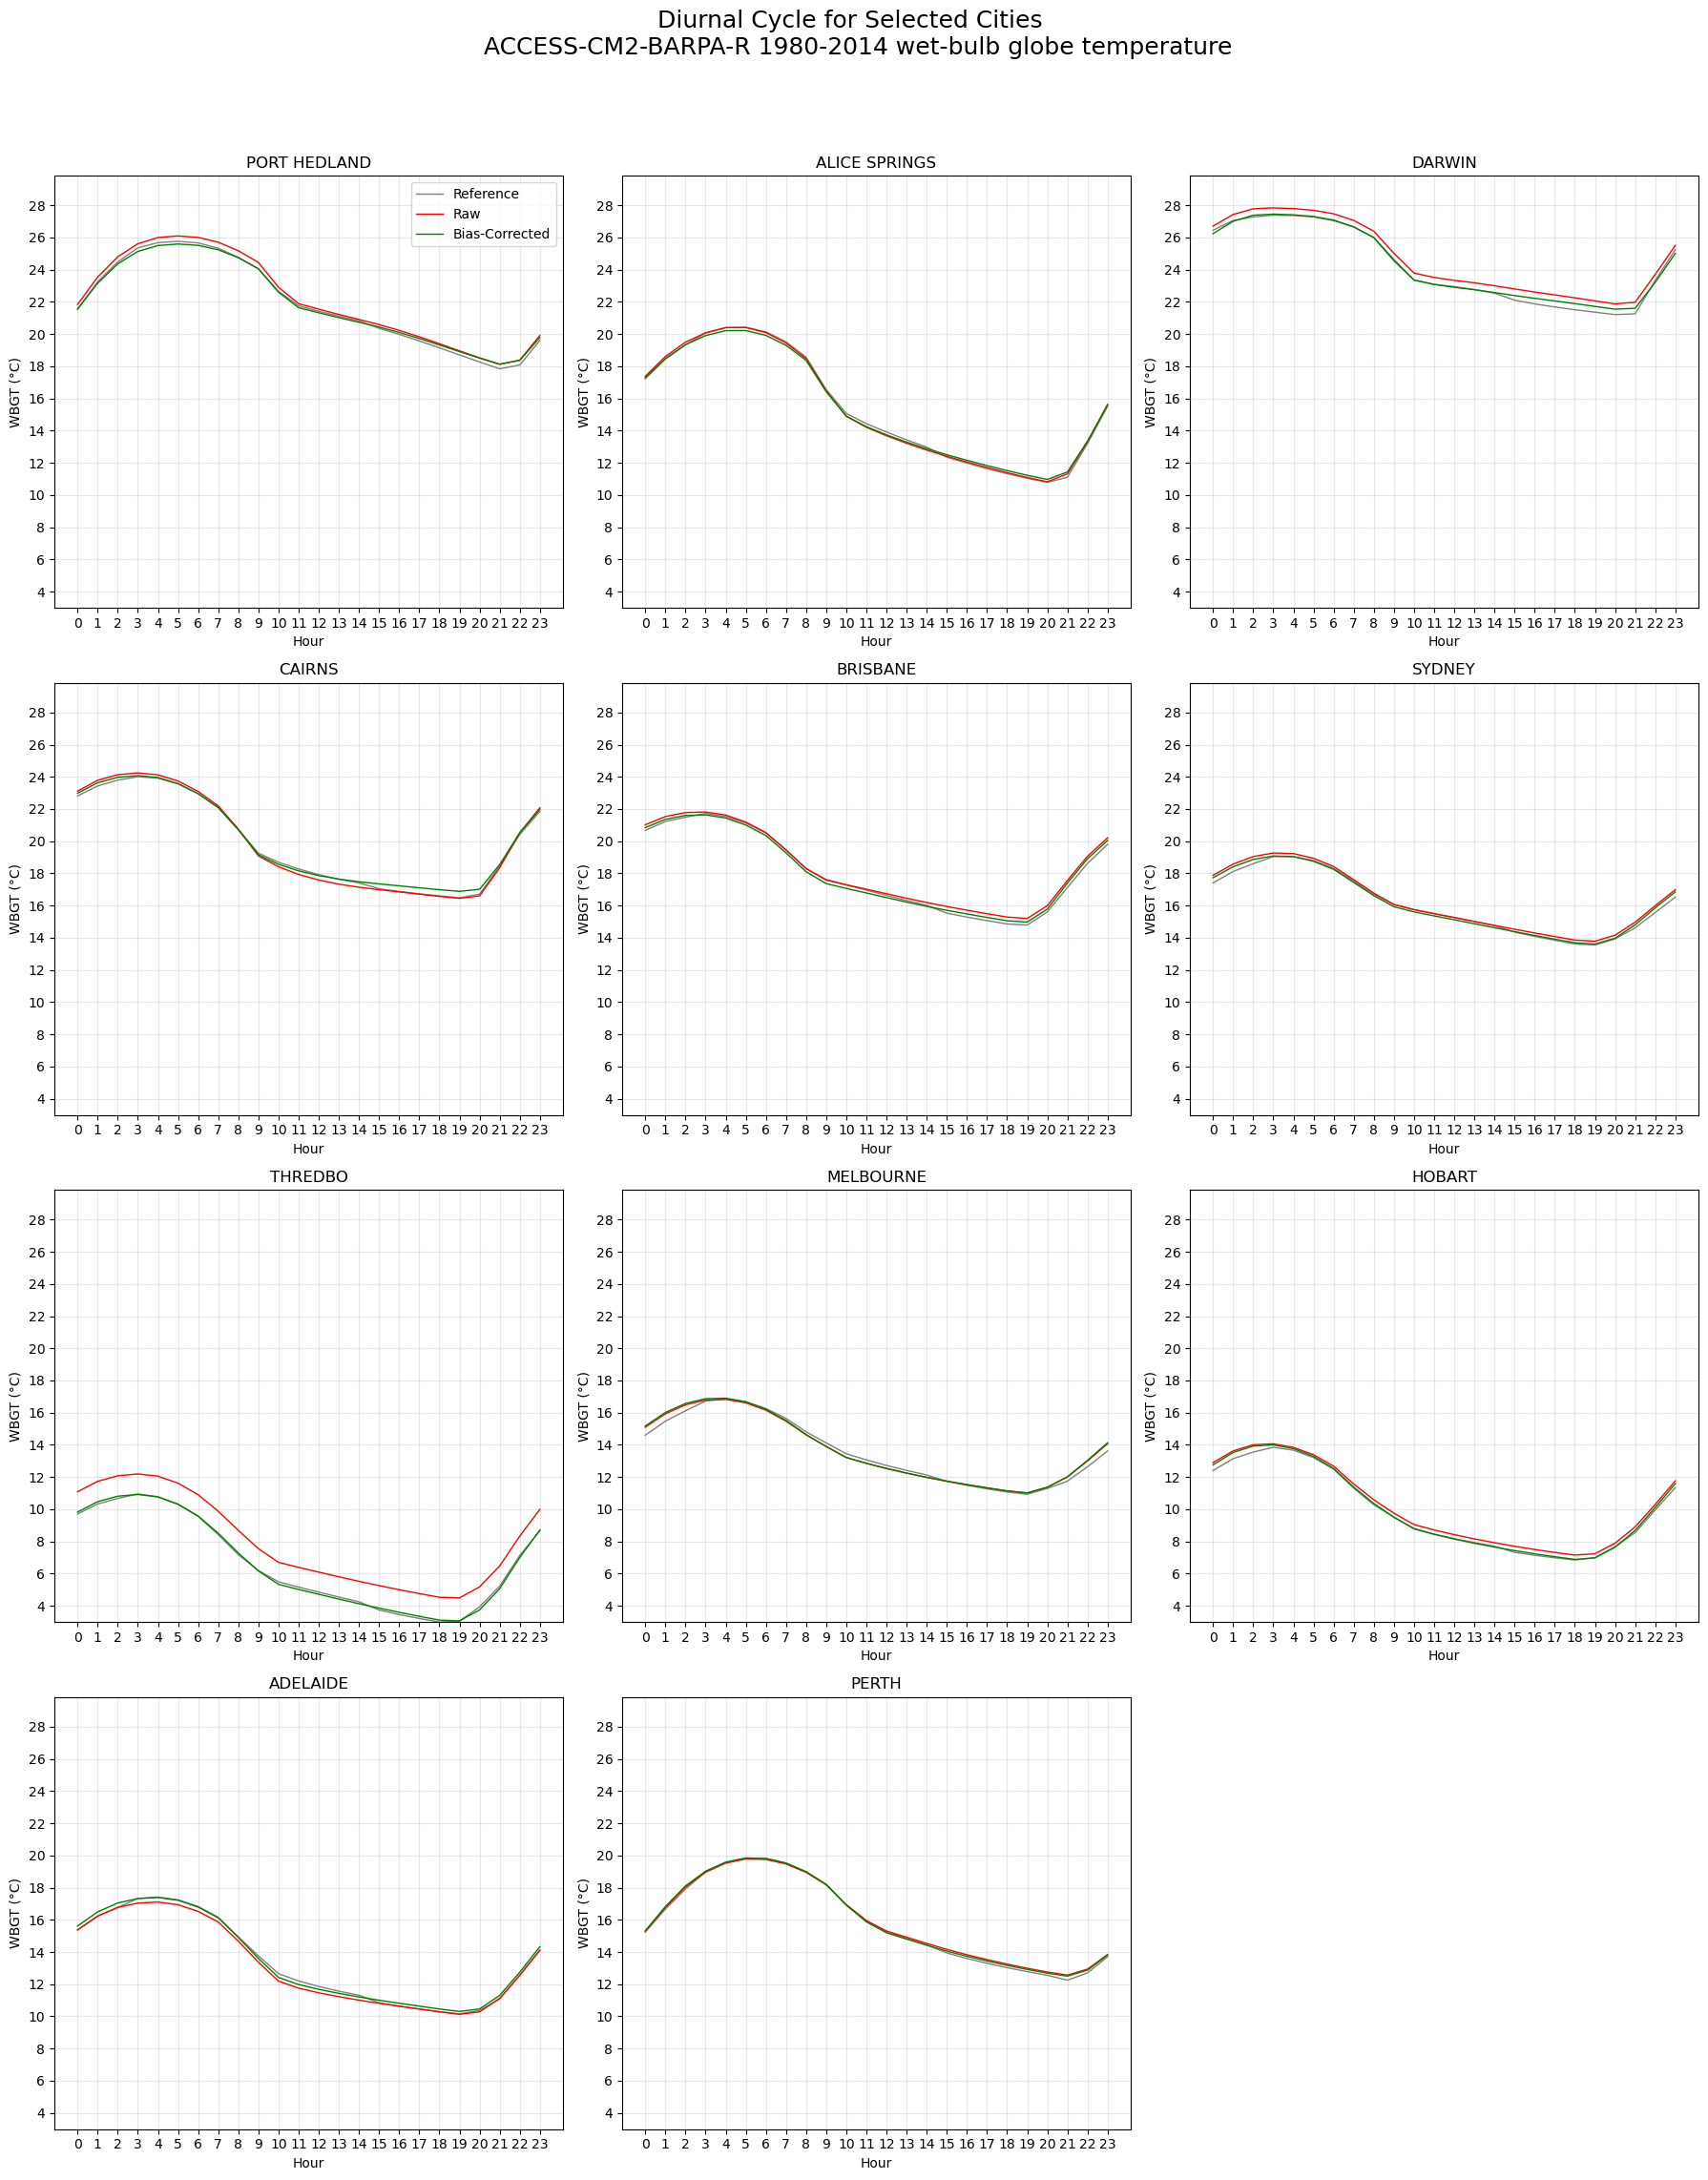

In [9]:
# Diurnal cycle for raw, corrected and reference for specific regions/location
task="diurnal-cycle-cities"
calc= "diurnal cycle cities"
# Get list of cities
cities_list = diurnal_df['City'].unique()
n_cities = len(cities_list)

# Plot
cols = 3
rows = (n_cities + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

# global y-axis limits for consistency
y_min = diurnal_df[['Hourly_Ref', 'Hourly_Raw', 'Hourly_BC']].min().min()
y_max = diurnal_df[['Hourly_Ref', 'Hourly_Raw', 'Hourly_BC']].max().max()

for i, city in enumerate(cities_list):
    ax = axes[i]
    diurnal_city = diurnal_df[diurnal_df['City'] == city]

    # Plot 
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_Ref'], label='Reference', color='grey', linewidth=1)
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_Raw'], label='Raw', color='red', linewidth=1)
    ax.plot(diurnal_city['Hour'], diurnal_city['Hourly_BC'], label='Bias-Corrected', color='green', linewidth=1)

    ax.set_title(city.upper())
    ax.set_xlabel('Hour')
    ax.set_ylabel('WBGT (°C)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(24))
    ax.set_yticks([round(x, 1) for x in range(int(y_min), int(y_max) + 4, 2)])
    ax.set_ylim(y_min, y_max + 2)

    if i == 0:
        ax.legend()

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Diurnal Cycle for Selected Cities \n {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {name}" , fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Plot hourly Mean bias

# Compute bias
bias_raw = raw - ref
bias_corrected = corrected - ref


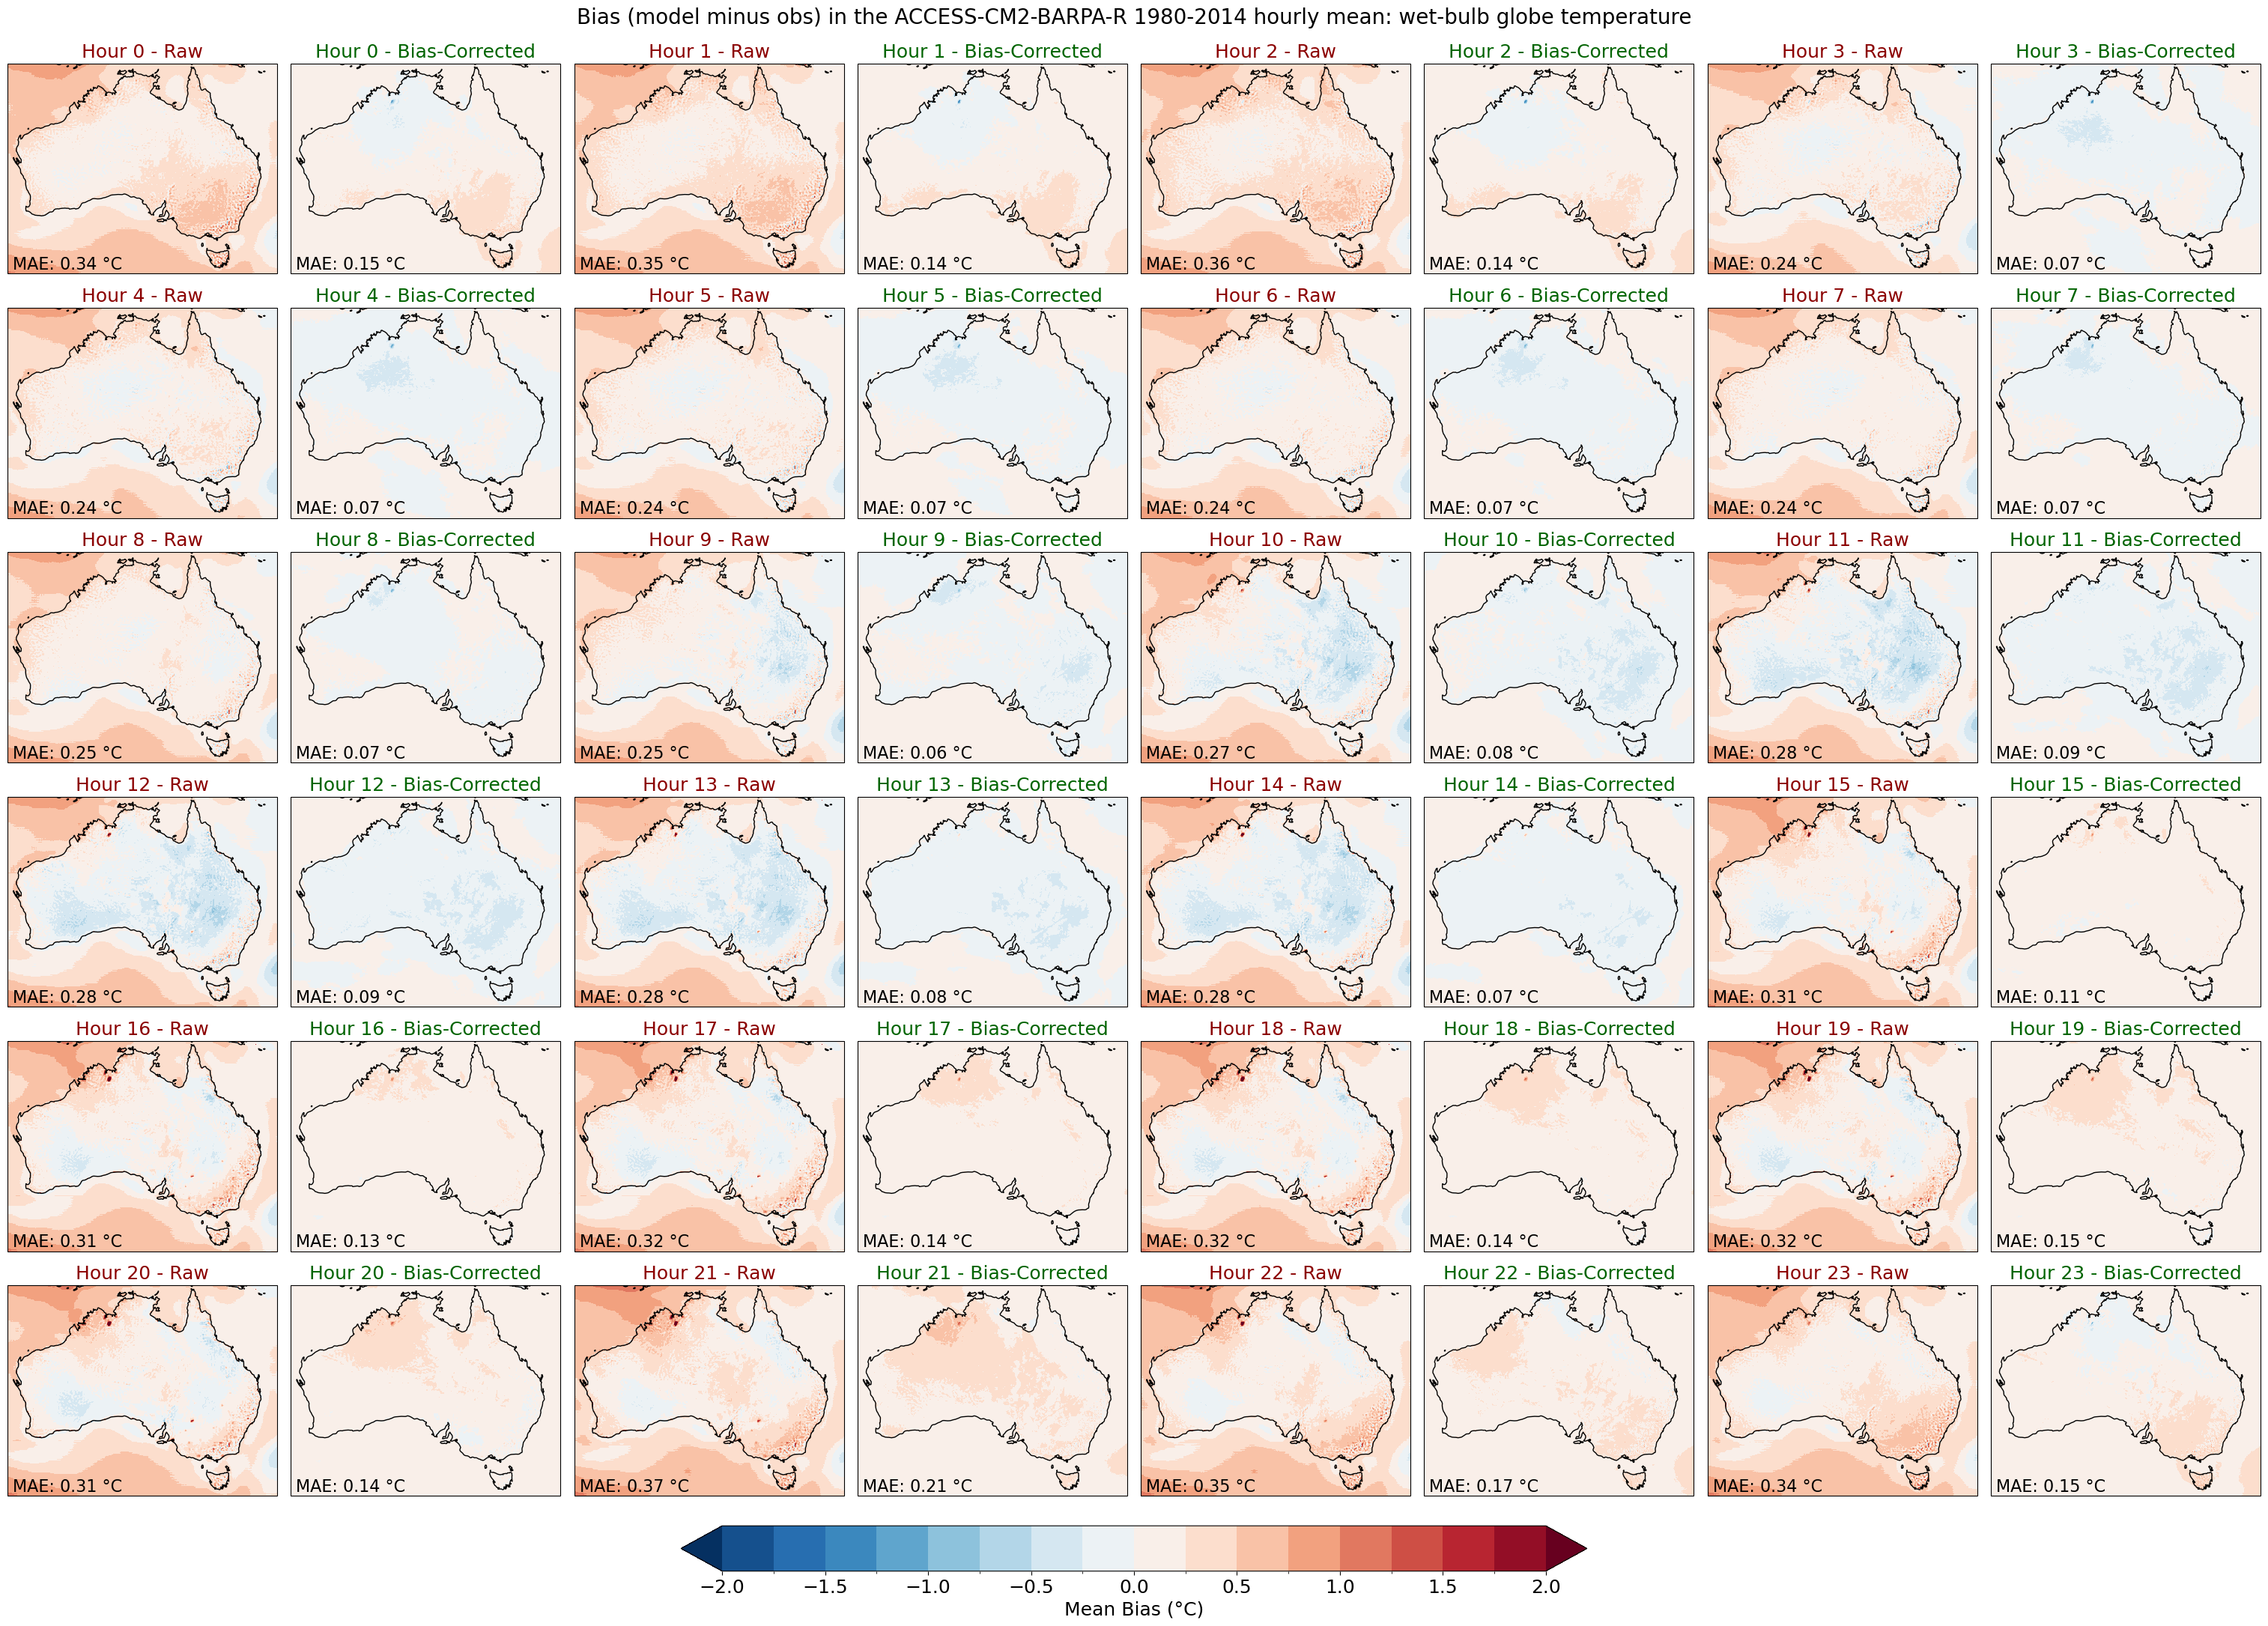

In [15]:
task="hourly_mean_bias"
calc= "hourly mean bias"

levels_bias = np.arange(-2, 2.25, 0.25)
cmap = 'RdBu_r'
units = '°C'


bias_stats = []


# Plot
nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(32, 24),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# spacing between rows, columns, and title
fig.subplots_adjust(top=0.90, bottom=0.06, left=0.03, right=0.97, hspace=0.15, wspace=0.05)


hourly_stats = []
# Plot each hour
for hour in range(24):
    bias_raw_hour = bias_raw.sel(time=bias_raw['time'].dt.hour == hour).mean(dim='time')
    bias_corrected_hour = bias_corrected.sel(time=bias_corrected['time'].dt.hour == hour).mean(dim='time')

    mae_raw = float(abs(bias_raw_hour).mean())
    mae_corrected = float(abs(bias_corrected_hour).mean())

   
    # Compute max and min for this hour
    raw_max = float(bias_raw_hour.max().values)
    raw_min = float(bias_raw_hour.min().values)
    corrected_max = float(bias_corrected_hour.max().values)
    corrected_min = float(bias_corrected_hour.min().values)
    hourly_stats.append([hour, raw_min, raw_max, corrected_min, corrected_max])
 

    # Raw bias subplot
    ax_raw = axes[hour * 2]
    bias_raw_hour.plot(ax=ax_raw, transform=ccrs.PlateCarree(),
                       cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_raw.text(0.02, 0.02, f'MAE: {mae_raw:.2f} {units}', transform=ax_raw.transAxes, fontsize=16)
    ax_raw.set_title(f'Hour {hour} - Raw', fontsize=18, color='darkred')
    ax_raw.coastlines()
    ax_raw.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Corrected bias subplot
    ax_corrected = axes[hour * 2 + 1]
    bias_corrected_hour.plot(ax=ax_corrected, transform=ccrs.PlateCarree(),
                             cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_corrected.text(0.02, 0.02, f'MAE: {mae_corrected:.2f} {units}', transform=ax_corrected.transAxes, fontsize=16)
    ax_corrected.set_title(f'Hour {hour} - Bias-Corrected', fontsize=18, color='darkgreen')
    ax_corrected.coastlines()
    ax_corrected.add_feature(cfeature.BORDERS, linewidth=0.5)

# Shared colorbar 
norm = mpl.colors.BoundaryNorm(boundaries=levels_bias, ncolors=plt.get_cmap(cmap).N, extend='both')
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', location='bottom', pad=0.02, fraction=0.03, extend='both')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(f'Mean Bias ({units})', fontsize=18)


fig.suptitle(f"Bias (model minus obs) in the {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} hourly mean: {name}",
             fontsize=20, y=0.93)
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

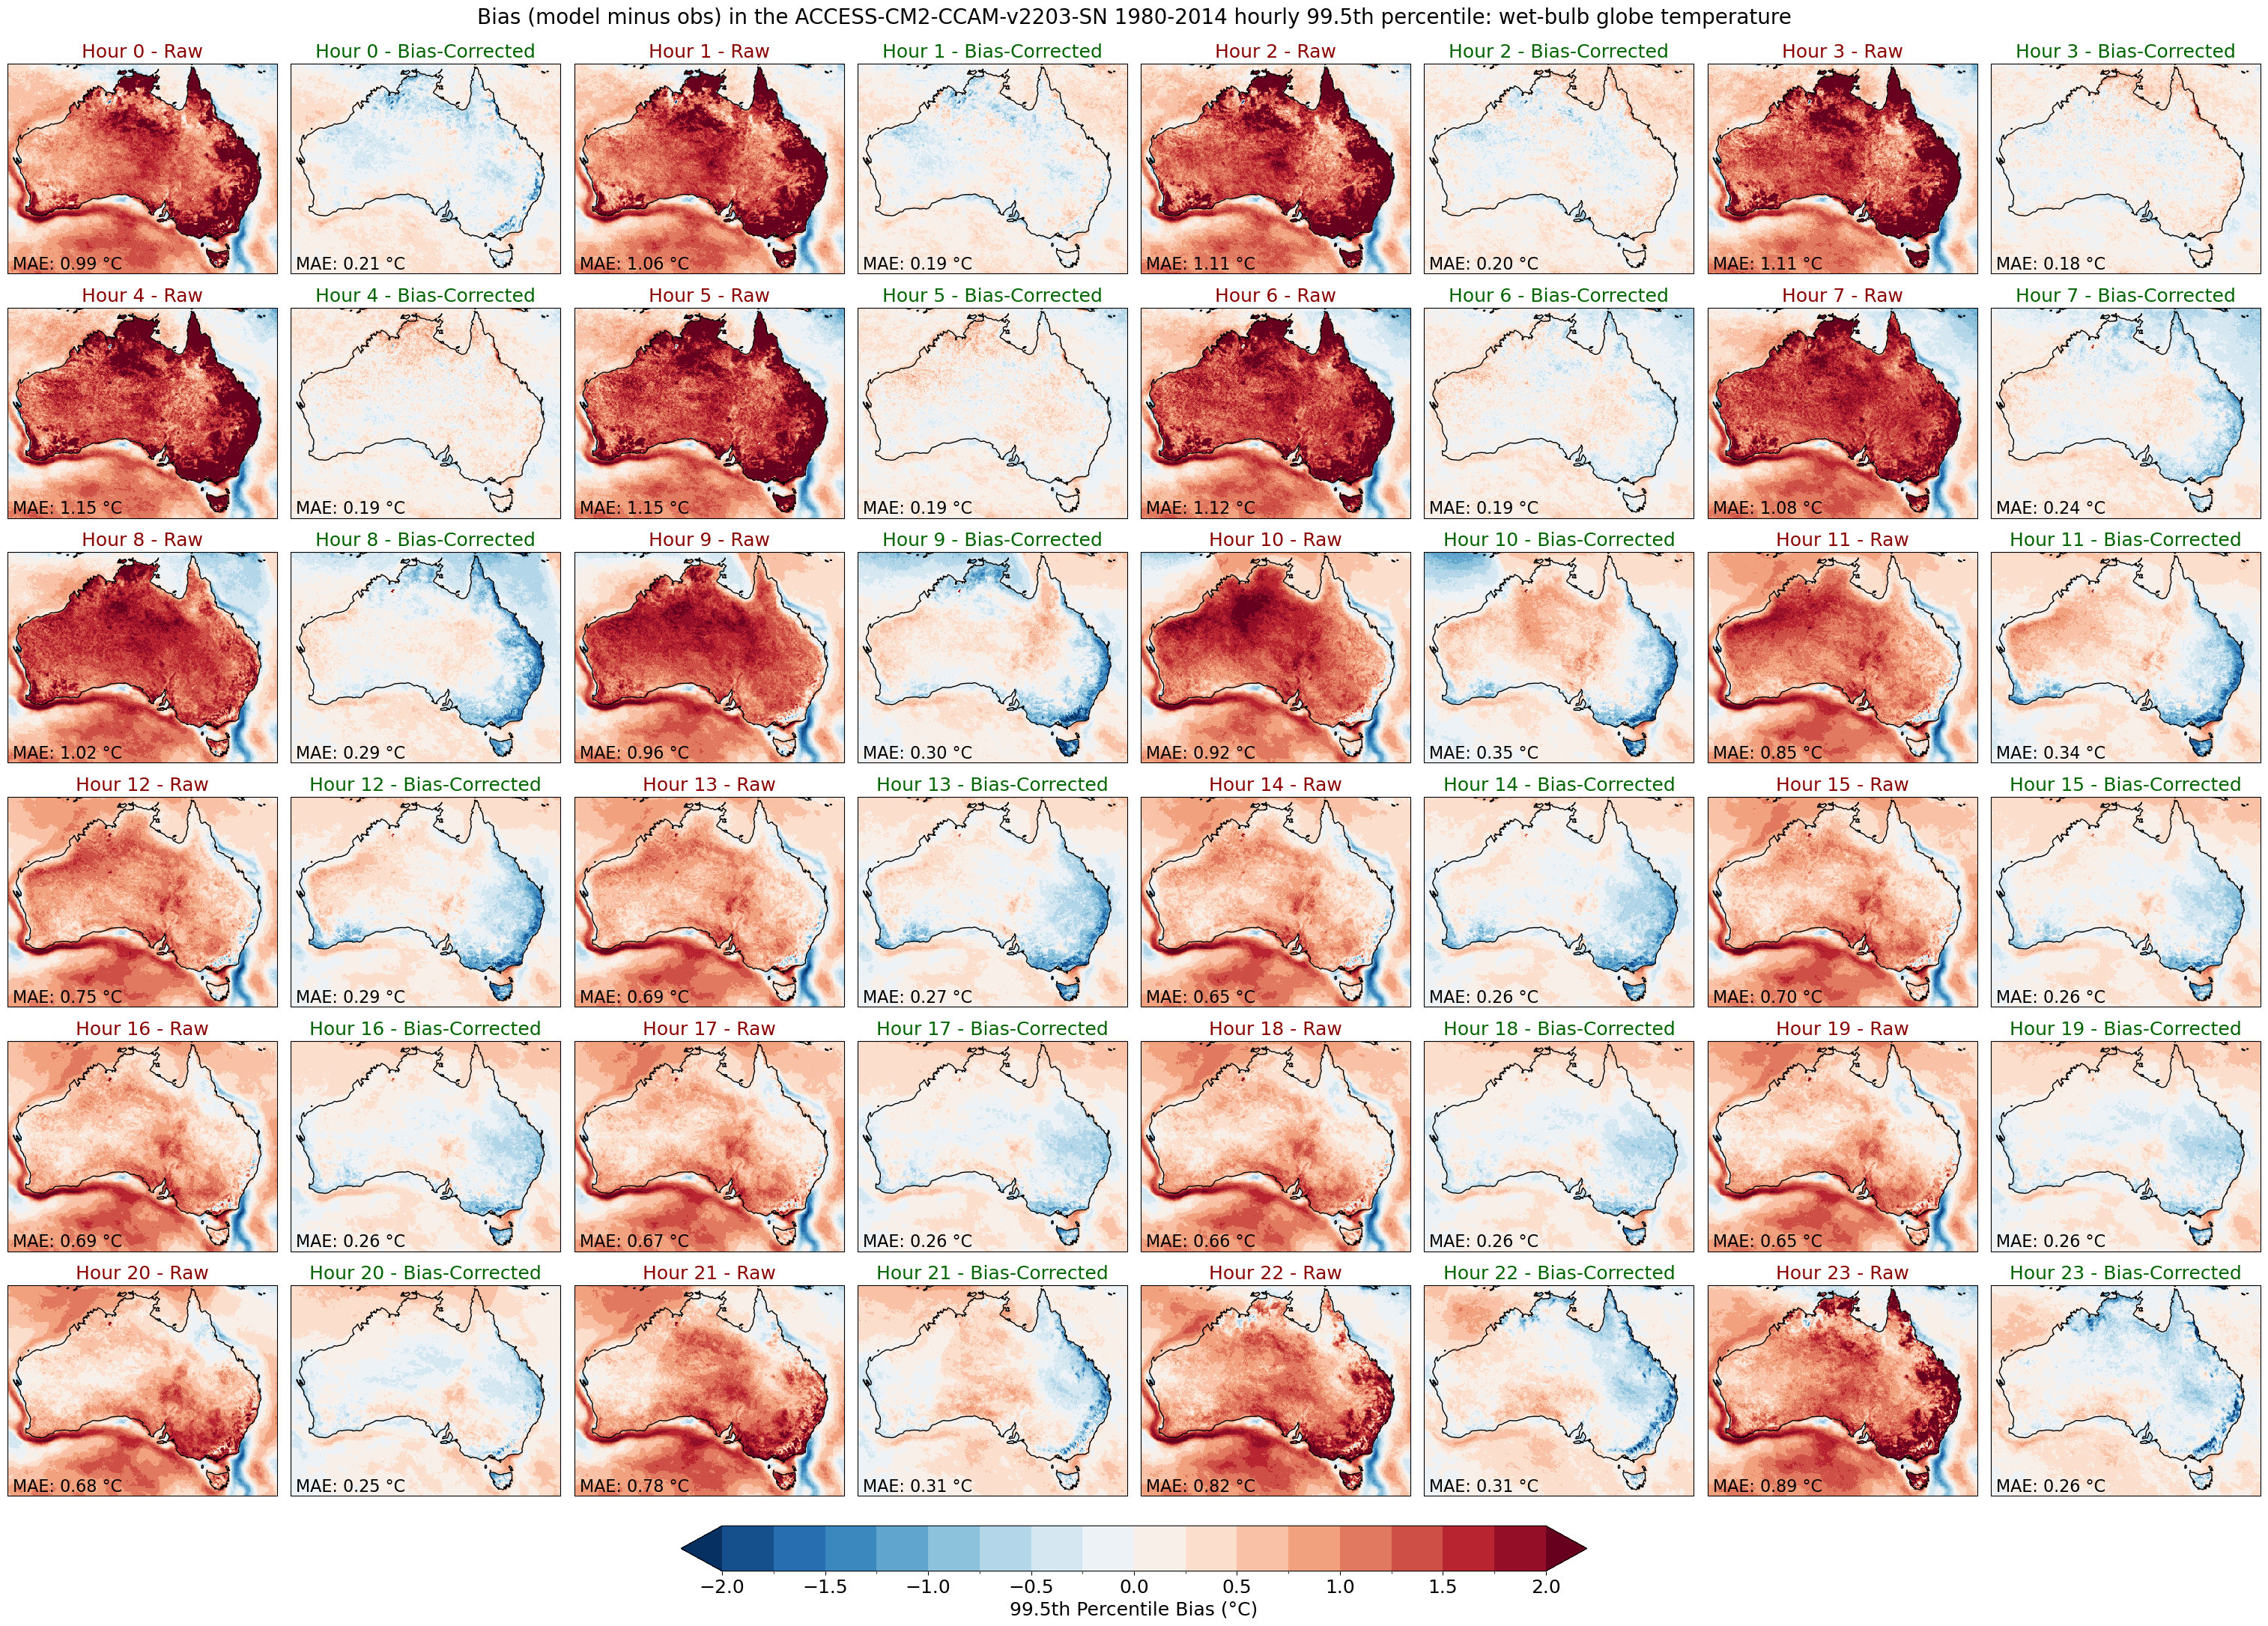

In [6]:
task="hourly_percentile_bias"
calc= "hourly percentile bias"

levels_bias = np.arange(-2, 2.25, 0.25)
cmap = 'RdBu_r'
units = '°C'


bias_stats = []

nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(32, 24),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# spacing between rows, columns, and title
fig.subplots_adjust(top=0.90, bottom=0.06, left=0.03, right=0.97,
                    hspace=0.15, wspace=0.05)

hourly_stats = []
# Plot each hour
for hour in range(24):
    ref_perc = ref.sel(time=ref['time'].dt.hour == hour).quantile(0.995, dim='time')
    raw_perc = raw.sel(time=raw['time'].dt.hour == hour).quantile(0.995, dim='time')
    corrected_perc = corrected.sel(time=corrected['time'].dt.hour == hour).quantile(0.995, dim='time')

    bias_raw_hour = raw_perc - ref_perc
    bias_corrected_hour = corrected_perc - ref_perc
    mae_raw = float(abs(bias_raw_hour).mean())
    mae_corrected = float(abs(bias_corrected_hour).mean())

   
    # Compute max and min for this hour
    raw_max = float(bias_raw_hour.max().values)
    raw_min = float(bias_raw_hour.min().values)
    corrected_max = float(bias_corrected_hour.max().values)
    corrected_min = float(bias_corrected_hour.min().values)
    hourly_stats.append([hour, raw_min, raw_max, corrected_min, corrected_max])
 

    # Raw bias subplot
    ax_raw = axes[hour * 2]
    bias_raw_hour.plot(ax=ax_raw, transform=ccrs.PlateCarree(),
                       cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_raw.text(0.02, 0.02, f'MAE: {mae_raw:.2f} {units}', transform=ax_raw.transAxes, fontsize=16)
    ax_raw.set_title(f'Hour {hour} - Raw', fontsize=18, color='darkred')
    ax_raw.coastlines()
    ax_raw.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Corrected bias subplot
    ax_corrected = axes[hour * 2 + 1]
    bias_corrected_hour.plot(ax=ax_corrected, transform=ccrs.PlateCarree(),
                             cmap=cmap, levels=levels_bias, extend='both', add_colorbar=False)
    ax_corrected.text(0.02, 0.02, f'MAE: {mae_corrected:.2f} {units}', transform=ax_corrected.transAxes, fontsize=16)
    ax_corrected.set_title(f'Hour {hour} - Bias-Corrected', fontsize=18, color='darkgreen')
    ax_corrected.coastlines()
    ax_corrected.add_feature(cfeature.BORDERS, linewidth=0.5)

# Shared colorbar 
norm = mpl.colors.BoundaryNorm(boundaries=levels_bias, ncolors=plt.get_cmap(cmap).N, extend='both')
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', location='bottom', pad=0.02, fraction=0.03, extend='both')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(f'99.5th Percentile Bias ({units})', fontsize=18)

fig.suptitle(f"Bias (model minus obs) in the {gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} hourly 99.5th percentile: {name}", fontsize=20, y=0.93)
outfile=f"/g/data/xv83/users/at2708/bias_adjustment_acs_qme/qme_dev_hourly/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

In [7]:
hourly_stats 

[[0,
  -3.082605743408198,
  5.403543014526367,
  -2.9366480350494335,
  1.808943128585799],
 [1,
  -3.791108932495078,
  5.864652633666989,
  -2.255528039932244,
  1.2201504516601815],
 [2,
  -4.181675796508756,
  6.203381118774402,
  -2.6904133796691525,
  1.8123472595214807],
 [3,
  -4.167197799682615,
  6.232981491088861,
  -2.3938702392577937,
  2.30736099243164],
 [4,
  -4.462990341186529,
  6.658430862426762,
  -1.715620489120429,
  2.2781866264343265],
 [5,
  -4.3497786712646445,
  6.404685897827189,
  -1.5791583633422697,
  1.5287363815307735],
 [6,
  -4.3216431427001964,
  5.9168021392822325,
  -1.9072796821594196,
  1.4523191452026367],
 [7,
  -3.6747714996337884,
  5.359349746704098,
  -2.4015691280364955,
  2.0457002258300747],
 [8,
  -2.943454666137704,
  4.501343612670901,
  -3.1666509437561032,
  3.1097622871398585],
 [9,
  -2.677251968383729,
  3.68816581726065,
  -5.03635125160217,
  3.3712157821655353],
 [10,
  -2.117574996948246,
  2.944822921752941,
  -2.6383638477